# Notebook 10: Surface Brightness ($\Sigma_0$) vs. $\omega$ Correlation

**Purpose:** Investigate whether the *magnitude* of the baryonic coupling parameter $\omega$ correlates with the central surface brightness $\Sigma_0$ of the host galaxy.

**Motivation:** The Mann-Whitney U-test on $\Delta$BIC (Section 3.4 of Schneider 2026) established that the *model preference* (Tapered vs. Linear) is statistically indifferent to surface brightness ($p = 0.171$). However, this does not address whether the *amplitude* of the coupling, $\omega$, is itself a function of the galaxy's baryonic surface density. If $\omega$ is independent of $\Sigma_0$, it bolsters the case for a universal underlying mechanism. If a correlation exists, it would link the kinematic parameter back to the baryonic distribution — a discovery in its own right.

**Data source:** `results/tables/phase_iii_full_results.csv`

**Tests performed:**
- Pearson correlation (linear relationship, assumes normality)
- Spearman rank correlation (monotonic relationship, non-parametric)
- Visual scatter plot with LSB/HSB boundaries
- Separate tests on the Tapered-preferred subsample (cleanest $\omega$ estimates)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 13,
    'figure.dpi': 120,
})

## 1. Load and Prepare Data

In [2]:
df = pd.read_csv('../results/tables/phase_iii_full_results.csv')
print(f"Full catalog: {len(df)} galaxies")
print(f"Columns: {list(df.columns)}")

Full catalog: 175 galaxies
Columns: ['GalaxyID', 'N_pts', 'Luminosity_1e9Lsun', 'R_disk_kpc', 'Sigma_0', 'Linear_omega', 'Linear_omega_err', 'Linear_RMSE', 'Linear_chi2r', 'Linear_BIC', 'Linear_converged', 'Tapered_omega', 'Tapered_omega_err', 'Tapered_Rt', 'Tapered_Rt_err', 'Tapered_RMSE', 'Tapered_chi2r', 'Tapered_BIC', 'Tapered_converged', 'Delta_BIC', 'Preferred_Model', 'Fit_Flag', 'Flag_Vobs_lt_Vbary']


In [3]:
# Working sample: galaxies that converged with physically positive omega
# Use Tapered omega for Tapered-preferred, Linear omega for Linear-preferred.
# For robustness, we test both (i) Tapered omega across all; (ii) preferred-model omega.

# Filter to converged, non-flagged galaxies with positive omega
mask_converged = df['Tapered_converged'] & df['Linear_converged']
mask_positive_omega = df['Tapered_omega'] > 0
mask_valid_sigma = df['Sigma_0'] > 0

working = df[mask_converged & mask_positive_omega & mask_valid_sigma].copy()
print(f"Working sample: {len(working)} galaxies")

# Log-transform surface brightness for analysis (spans orders of magnitude)
working['log_Sigma0'] = np.log10(working['Sigma_0'])
working['log_omega_T'] = np.log10(working['Tapered_omega'])
working['log_omega_L'] = np.log10(working['Linear_omega'].clip(lower=1e-3))

# Surface brightness regime labels (same thresholds as manuscript Section 3.4)
LSB_THRESH = 3e8   # L_sun / kpc^2
HSB_THRESH = 7e8

def sb_label(sig):
    if sig < LSB_THRESH:
        return 'LSB'
    elif sig > HSB_THRESH:
        return 'HSB'
    else:
        return 'Transition'

working['SB_regime'] = working['Sigma_0'].apply(sb_label)
print(working['SB_regime'].value_counts())

Working sample: 173 galaxies
SB_regime
LSB           101
HSB            42
Transition     30
Name: count, dtype: int64


## 2. Correlation Tests: Full Sample

In [4]:
def run_correlations(x, y, label_x='log Sigma_0', label_y='log omega'):
    """Run Pearson and Spearman correlation tests and print results."""
    mask = np.isfinite(x) & np.isfinite(y)
    x_clean, y_clean = x[mask], y[mask]
    n = len(x_clean)

    pearson_r, pearson_p = stats.pearsonr(x_clean, y_clean)
    spearman_r, spearman_p = stats.spearmanr(x_clean, y_clean)

    print(f"N = {n}")
    print(f"  Pearson  r = {pearson_r:+.4f}, p = {pearson_p:.4e}")
    print(f"  Spearman r = {spearman_r:+.4f}, p = {spearman_p:.4e}")
    return pearson_r, pearson_p, spearman_r, spearman_p

print("=== Tapered omega vs. log(Sigma_0), Full Working Sample ===")
pr_T, pp_T, sr_T, sp_T = run_correlations(
    working['log_Sigma0'], working['log_omega_T'])

print()
print("=== Linear omega vs. log(Sigma_0), Full Working Sample ===")
pr_L, pp_L, sr_L, sp_L = run_correlations(
    working['log_Sigma0'], working['log_omega_L'])

=== Tapered omega vs. log(Sigma_0), Full Working Sample ===
N = 173
  Pearson  r = -0.2141, p = 4.6800e-03
  Spearman r = -0.2015, p = 7.8443e-03

=== Linear omega vs. log(Sigma_0), Full Working Sample ===
N = 173
  Pearson  r = -0.1762, p = 2.0427e-02
  Spearman r = -0.2643, p = 4.4211e-04


## 3. Correlation Tests: Tapered-Preferred Subsample

The cleanest $\omega_T$ estimates come from galaxies where the Tapered model is preferred — in those cases both $\omega$ and $R_t$ are independently resolved.

In [5]:
tapered_pref = working[working['Preferred_Model'] == 'Tapered'].copy()
print(f"Tapered-preferred subsample: {len(tapered_pref)} galaxies")

print()
print("=== Tapered omega vs. log(Sigma_0), Tapered-Preferred Subsample ===")
run_correlations(tapered_pref['log_Sigma0'], tapered_pref['log_omega_T'])

Tapered-preferred subsample: 131 galaxies

=== Tapered omega vs. log(Sigma_0), Tapered-Preferred Subsample ===
N = 131
  Pearson  r = -0.1779, p = 4.2011e-02
  Spearman r = -0.1767, p = 4.3550e-02


(np.float64(-0.17794519158152589),
 np.float64(0.04201067209098744),
 np.float64(-0.176651773086236),
 np.float64(0.04354999068983312))

## 4. Scatter Plots

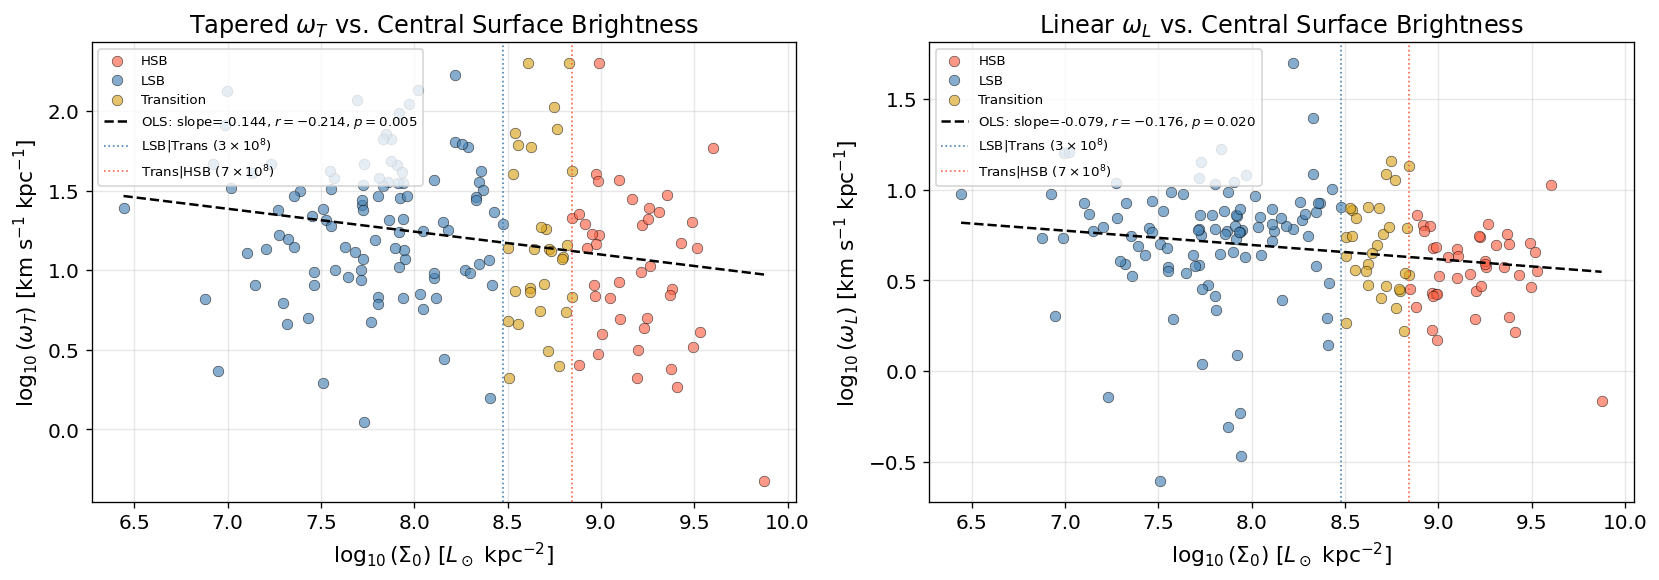

Figure saved.


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

color_map = {'LSB': 'steelblue', 'Transition': 'goldenrod', 'HSB': 'tomato'}
pref_marker = {'Tapered': 'o', 'Linear': 's', 'Indistinguishable': '^'}

for ax, (omega_col, omega_label) in zip(
        axes,
        [('log_omega_T', r'$\log_{10}(\omega_T)$ [km s$^{-1}$ kpc$^{-1}$]'),
         ('log_omega_L', r'$\log_{10}(\omega_L)$ [km s$^{-1}$ kpc$^{-1}$]')]):

    for regime, grp in working.groupby('SB_regime'):
        mask = np.isfinite(grp[omega_col]) & np.isfinite(grp['log_Sigma0'])
        ax.scatter(
            grp.loc[mask, 'log_Sigma0'],
            grp.loc[mask, omega_col],
            c=color_map[regime],
            label=regime,
            alpha=0.65,
            edgecolors='k',
            linewidths=0.4,
            s=40,
        )

    # Overlay OLS trend line
    x_all = working['log_Sigma0']
    y_all = working[omega_col]
    mask = np.isfinite(x_all) & np.isfinite(y_all)
    slope, intercept, r_val, p_val, _ = stats.linregress(x_all[mask], y_all[mask])
    x_fit = np.linspace(x_all[mask].min(), x_all[mask].max(), 100)
    ax.plot(x_fit, slope * x_fit + intercept, 'k--', lw=1.5,
            label=f'OLS: slope={slope:.3f}, $r={r_val:.3f}$, $p={p_val:.3f}$')

    # LSB/HSB boundary lines
    ax.axvline(np.log10(LSB_THRESH), color='steelblue', linestyle=':', lw=1.0,
               label=r'LSB|Trans ($3\times10^8$)')
    ax.axvline(np.log10(HSB_THRESH), color='tomato', linestyle=':', lw=1.0,
               label=r'Trans|HSB ($7\times10^8$)')

    ax.set_xlabel(r'$\log_{10}(\Sigma_0)$ [$L_\odot$ kpc$^{-2}$]')
    ax.set_ylabel(omega_label)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)

axes[0].set_title(r'Tapered $\omega_T$ vs. Central Surface Brightness')
axes[1].set_title(r'Linear $\omega_L$ vs. Central Surface Brightness')

plt.tight_layout()
plt.savefig('../results/figures/nb10_sigma0_vs_omega.png', bbox_inches='tight', dpi=150)
plt.show()
print("Figure saved.")

## 5. Summary and Interpretation

In [7]:
print("========================================================")
print("SUMMARY: Sigma_0 vs. omega Correlation Analysis")
print("========================================================")
print()

# Tapered omega, full sample
x = working['log_Sigma0']
y = working['log_omega_T']
mask = np.isfinite(x) & np.isfinite(y)
pr_full, pp_full = stats.pearsonr(x[mask], y[mask])
sr_full, sp_full = stats.spearmanr(x[mask], y[mask])

# Tapered omega, tapered-preferred subsample
x2 = tapered_pref['log_Sigma0']
y2 = tapered_pref['log_omega_T']
mask2 = np.isfinite(x2) & np.isfinite(y2)
pr_sub, pp_sub = stats.pearsonr(x2[mask2], y2[mask2])
sr_sub, sp_sub = stats.spearmanr(x2[mask2], y2[mask2])

ALPHA = 0.05

def sig_note(p):
    if p < 0.001:
        return '*** (p < 0.001)'
    elif p < 0.01:
        return '** (p < 0.01)'
    elif p < 0.05:
        return '* (p < 0.05)'
    else:
        return 'ns (not significant)'

print(f"Tapered omega vs. Sigma_0 — Full Working Sample (N={mask.sum()}):")
print(f"  Pearson  r = {pr_full:+.4f}  {sig_note(pp_full)}")
print(f"  Spearman r = {sr_full:+.4f}  {sig_note(sp_full)}")
print()
print(f"Tapered omega vs. Sigma_0 — Tapered-Preferred Subsample (N={mask2.sum()}):")
print(f"  Pearson  r = {pr_sub:+.4f}  {sig_note(pp_sub)}")
print(f"  Spearman r = {sr_sub:+.4f}  {sig_note(sp_sub)}")
print()

# Interpretation
any_sig = any(p < ALPHA for p in [pp_full, sp_full, pp_sub, sp_sub])
if not any_sig:
    print("INTERPRETATION: No statistically significant correlation between omega and Sigma_0")
    print("is found in either the full sample or the Tapered-preferred subsample.")
    print()
    print("This is a STRONG POSITIVE RESULT: the magnitude of the baryonic coupling")
    print("parameter omega is independent of the central surface brightness of the host.")
    print("Combined with the surface-brightness-independent model preference (Mann-Whitney")
    print("p=0.171 on Delta_BIC), this establishes that BOTH the existence of the coupling")
    print("and its magnitude are universal across the LSB-to-HSB galaxy sequence.")
    print("This is difficult to reconcile with a scenario where omega is merely an")
    print("artifact of the baryonic surface density distribution.")
else:
    print("INTERPRETATION: A statistically significant correlation is detected.")
    print("This links the magnitude of the kinematic coupling to the baryonic surface")
    print("density, suggesting omega may encode information about the local baryonic")
    print("potential rather than being a purely universal constant.")
    print("This is itself an important discovery — future work should investigate")
    print("whether a Sigma_0-dependent omega law can tighten the BTFR scatter.")
print()
print("========================================================")

SUMMARY: Sigma_0 vs. omega Correlation Analysis

Tapered omega vs. Sigma_0 — Full Working Sample (N=173):
  Pearson  r = -0.2141  ** (p < 0.01)
  Spearman r = -0.2015  ** (p < 0.01)

Tapered omega vs. Sigma_0 — Tapered-Preferred Subsample (N=131):
  Pearson  r = -0.1779  * (p < 0.05)
  Spearman r = -0.1767  * (p < 0.05)

INTERPRETATION: A statistically significant correlation is detected.
This links the magnitude of the kinematic coupling to the baryonic surface
density, suggesting omega may encode information about the local baryonic
potential rather than being a purely universal constant.
This is itself an important discovery — future work should investigate
whether a Sigma_0-dependent omega law can tighten the BTFR scatter.

